In [51]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from DeepPeak.signals import generate_signal_dataset
from DeepPeak.utils.visualization import plot_training_history, SignalPlotter
from DeepPeak.utils.training_utils import dataset_split
from tensorflow.keras.callbacks import ModelCheckpoint # type: ignore
from tensorflow.keras.models import load_model  # type: ignore
from DeepPeak.models import build_ROI_model, permutation_invariant_loss, filter_predictions
from DeepPeak.utils.ROI import compute_rois_from_signals, get_positions_amplitudes

from tensorflow import keras

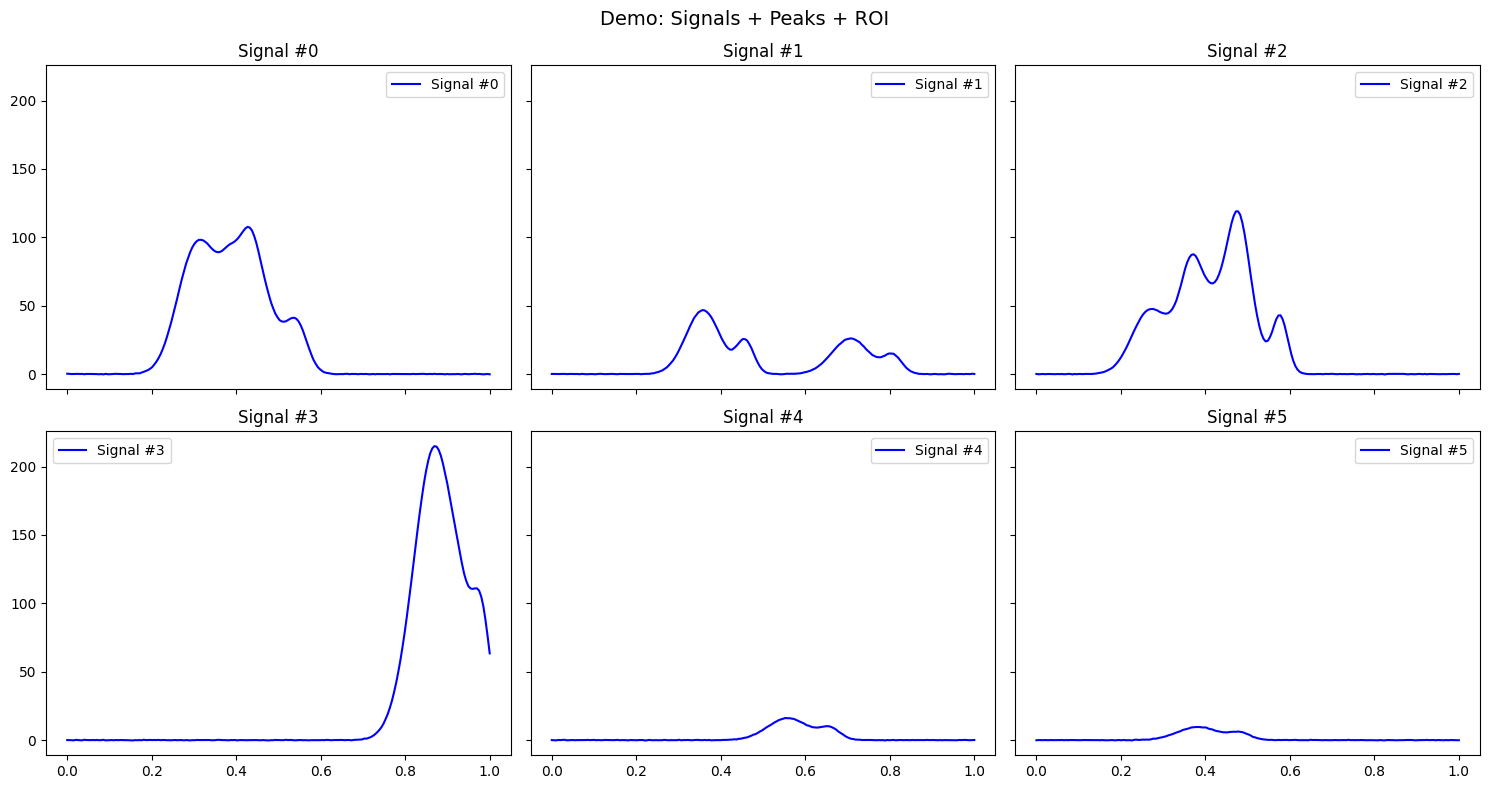

In [216]:
NUM_PEAKS = 3
SEQUENCE_LENGTH = 200
sample_count = 6000

signals, amplitudes, positions, widths, x_values, num_peaks = generate_signal_dataset(
    n_samples=sample_count,
    signal_type='asym_gaussian',
    sequence_length=SEQUENCE_LENGTH,
    n_peaks=(1, NUM_PEAKS),
    amplitude=(1, 100),
    position=(0.1, 0.9),
    width=(0.03, 0.05),
    noise_std=0.1,
    categorical_peak_count=False,
)


ROI = compute_rois_from_signals(
    signals=signals, positions=positions, width_in_pixels=3, amplitudes=amplitudes
)

plotter = SignalPlotter()
plotter.add_signals(signals)
# plotter.add_positions(positions)
# plotter.add_amplitudes(amplitudes)
# plotter.add_roi(ROI)
plotter.set_title("Demo: Signals + Peaks + ROI")
plotter.plot(n_examples=6, n_columns=3, random_select=False)

Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9513 - loss: 0.2757 - val_accuracy: 0.9828 - val_loss: 0.0704
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9766 - loss: 0.0639 - val_accuracy: 0.9843 - val_loss: 0.0599
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9806 - loss: 0.0580 - val_accuracy: 0.9855 - val_loss: 0.0539
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9821 - loss: 0.0520 - val_accuracy: 0.9863 - val_loss: 0.0454
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9837 - loss: 0.0482 - val_accuracy: 0.9882 - val_loss: 0.0401
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9852 - loss: 0.0445 - val_accuracy: 0.9889 - val_loss: 0.0388
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9860 - loss: 0.0410 - val_accuracy: 0.9901 - val_loss: 0.0348
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9870 - loss: 0.0377 - val_accura

/Users/m.poinsinetdesivry-houle/Desktop/GitRepositories/DeepPeak/DeepPeak/utils/visualization.py:207: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left')


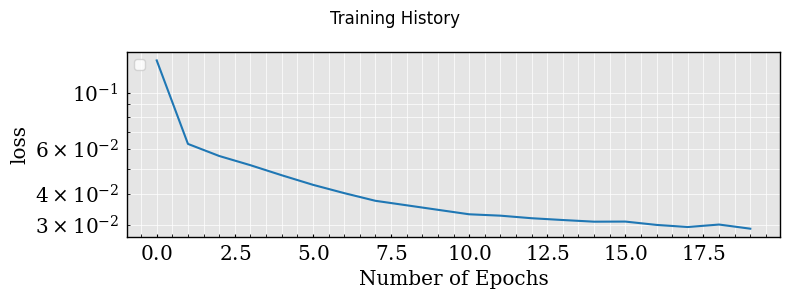

In [53]:
roi_model = build_ROI_model(SEQUENCE_LENGTH)

# Train the model
history = roi_model.fit(
    signals, ROI,
    validation_split=0.2,
    epochs=20,
    batch_size=32
)

plot_training_history(history, filtering=['*loss*'])

In [46]:
def get_middle_indices_1d_padded(one_hot_signal, max_groups, pad_val=-1):
    """
    Same as get_middle_indices_1d but returns a fixed-length array of size max_groups,
    padding with pad_val if necessary.
    
    Parameters:
        one_hot_signal (np.ndarray): 1D array of 0s and 1s.
        max_groups (int): The fixed length (maximum number of groups over the batch).
        pad_val (int): Value used for padding when a row has fewer groups.
    
    Returns:
        np.ndarray: 1D array of length max_groups containing the middle indices,
                    padded with pad_val.
    """
    mids = get_middle_indices_1d(one_hot_signal)
    padded = np.full(max_groups, pad_val, dtype=int)
    padded[:len(mids)] = mids
    return padded

def get_middle_indices_batch(roi_array, pad_val=-1):
    """
    Given an ROI array of shape (n_samples, signal_length) with 0s and 1s,
    return a 2D array of shape (n_samples, max_groups) where each row contains
    the middle index of each contiguous group of ones (ROI) in that sample,
    padded with pad_val (default -1) if a row has fewer groups.
    
    This function uses vectorized operations (np.pad, np.diff) and then applies
    a function rowwise via np.apply_along_axis (which is vectorized in C, even though
    it loops over rows internally).
    
    Parameters:
        roi_array (np.ndarray): 2D array with shape (n_samples, signal_length).
        pad_val (int): The value used to pad rows that have fewer groups than max_groups.
    
    Returns:
        np.ndarray: Array of shape (n_samples, max_groups) with the middle indices.
    
    Example:
        >>> roi = np.array([
        ...    [0, 1, 1, 1, 0, 1, 1, 0],
        ...    [1, 1, 0, 0, 1, 0, 1, 1]
        ... ])
        >>> get_middle_indices_batch(roi)
        array([[2, 5],
               [0, 4]])
        # (If one sample had three groups, the missing value would be filled with -1.)
    """
    n_samples, signal_length = roi_array.shape
    
    # First, compute the number of groups in each row.
    # We pad each row and compute the difference along axis 1.
    padded_roi = np.pad(roi_array, ((0,0), (1,1)), constant_values=0)
    diff = np.diff(padded_roi, axis=1)
    # For each row, count how many times we see a 0→1 transition.
    groups_count = np.sum(diff == 1, axis=1)
    max_groups = int(groups_count.max())
    
    # Use np.apply_along_axis to apply the padded version of the 1D function.
    # The lambda takes one row and returns an array of shape (max_groups,).
    result = np.apply_along_axis(lambda row: get_middle_indices_1d_padded(row, max_groups, pad_val), 1, roi_array)
    return result

In [211]:
test_signals, test_amplitudes, test_positions, test_widths, _, _ = generate_signal_dataset(
    n_samples=100,
    signal_type='gaussian',
    sequence_length=SEQUENCE_LENGTH,
    n_peaks=(1, NUM_PEAKS),
    amplitude=(1, 100),
    position=(0.1, 0.9),
    width=(0.03, 0.05),
    noise_std=0.1,
    categorical_peak_count=False,
)

predictions, uncertainty = filter_predictions(
    signals=test_signals,
    model=roi_model,
    n_samples=90,
    threshold=0.90,
    std_threshold=0.08
)



indices = get_middle_indices_batch(predictions, pad_val=-1)
plotter = SignalPlotter()
plotter.add_signals(test_signals)
plotter.add_positions(test_positions)
plotter.add_amplitudes(test_amplitudes)
plotter.add_roi(predictions.squeeze())


def multi_gauss(x, pos, width, amp):
    return amp * np.exp(-0.5 * ((x - pos) / width)**2)

plotter.add_custom_curves(
    curve_function=multi_gauss,
    label="Multi-Gauss",
    color="black",
    style="--",
    pos=test_positions,
    width=test_widths,
    amp=test_amplitudes
)

plotter.set_title("Demo: Signals + Peaks + ROI")
plotter.plot(n_examples=96, n_columns=3, random_select=True)

AttributeError: 'SignalPlotter' object has no attribute 'add_positions'

In [59]:
plotter.figure.savefig('model_example.png')
# ! pwd

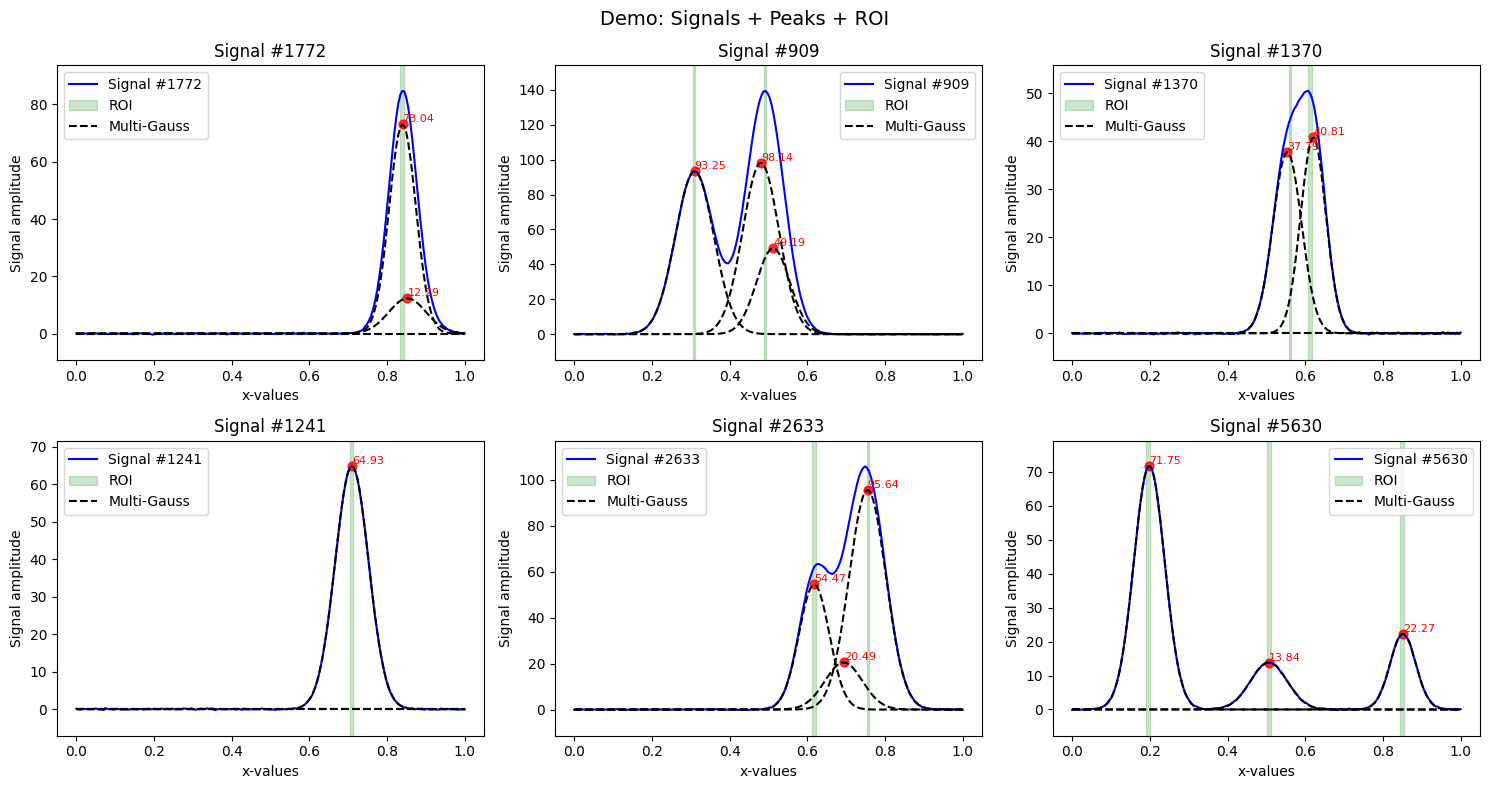

In [94]:
# ROI_prediction = roi_model.predict(signals, verbose=0)['ROI'][:, :, 0]
# ROI_prediction[ROI_prediction<0.5] = 0
# ROI_prediction[ROI_prediction>0.5] = 1


# plotter = SignalPlotter()
# plotter.add_signals(signals)
# plotter.add_positions(positions)
# plotter.add_amplitudes(amplitudes)
# plotter.add_roi(ROI_prediction)


# def multi_gauss(x, pos, width, amp):
#     return amp * np.exp(-0.5 * ((x - pos) / width)**2)

# plotter.add_custom_curves(
#     curve_function=multi_gauss,
#     label="Multi-Gauss",
#     color="black",
#     style="--",
#     pos=positions,
#     width=widths,
#     amp=amplitudes
# )

# plotter.set_title("Demo: Signals + Peaks + ROI")
# plotter.plot(n_examples=6, n_columns=3, random_select=True)

In [149]:
val_signals, val_amplitudes, val_positions, _, _, _ = generate_signal_dataset(
    n_samples=400,
    signal_type='gaussian',
    sequence_length=SEQUENCE_LENGTH,
    n_peaks=(1, NUM_PEAKS),
    amplitude=(1, 50),
    position=(0.1, 0.9),
    width=(0.03, 0.05),
    noise_std=0.1 * 1,
    categorical_peak_count=False,
)

roi_ground_truth = compute_rois_from_signals(
    signals=val_signals, positions=val_positions, width_in_pixels=3, amplitudes=val_amplitudes
)

roi_predictions, uncertainty = filter_predictions(
    signals=val_signals,
    model=roi_model,
    n_samples=90,
    threshold=0.90,
    std_threshold=0.01
)

# Compute segmentation metrics
metrics = compute_segmentation_metrics(roi_predictions, roi_ground_truth)

# Display the metrics
print("Segmentation Metrics for ROI Prediction:")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall:    {metrics['recall']:.4f}")
print(f"F1 Score:  {metrics['f1_score']:.4f}")
print(f"IoU:       {metrics['iou']:.4f}")
print(f"Dice:      {metrics['dice']:.4f}")

Segmentation Metrics for ROI Prediction:
Precision: 0.9767
Recall:    0.1088
F1 Score:  0.1957
IoU:       0.1085
Dice:      0.1957


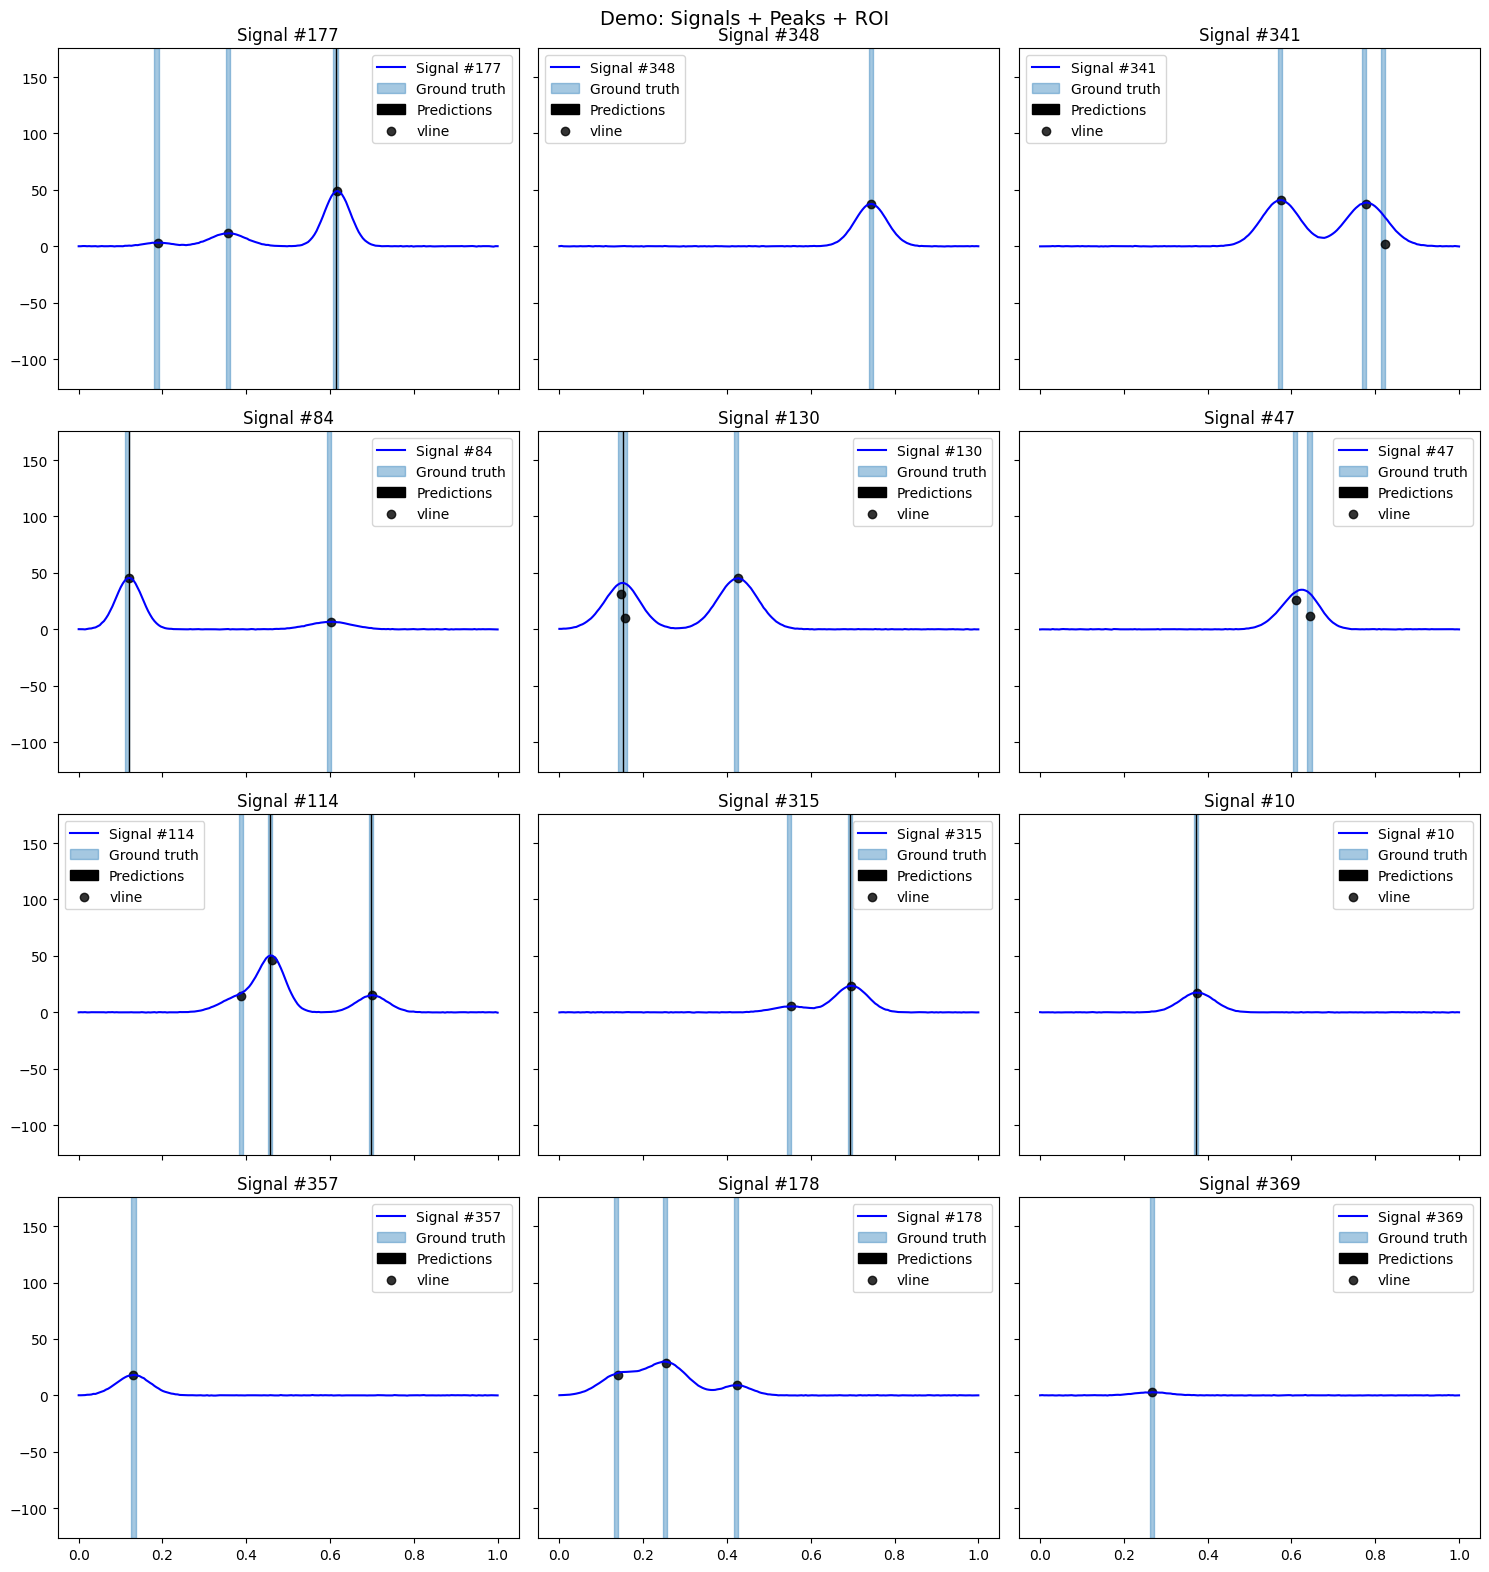

In [213]:

plotter = SignalPlotter()
plotter.add_signals(val_signals)
val_amplitudes[val_amplitudes==0] = np.nan
plotter.add_scatter(val_positions, val_amplitudes, color='black', label='vline')
plotter.add_roi(roi_ground_truth.squeeze(), color='C0', alpha=0.4, label='Ground truth')
plotter.add_roi(roi_predictions.squeeze(), color='black', alpha=1.0, label='Predictions')

plotter.set_title("Demo: Signals + Peaks + ROI")
plotter.plot(n_examples=12, n_columns=3, random_select=True)

In [177]:
val_positions.shape

(400, 3)

In [209]:
import numpy as np

def roi_containment_metric(roi_pred: np.ndarray, roi_gt: np.ndarray) -> dict:
    """
    Compute the ROI containment metric, which quantifies the fraction of the predicted
    ROI that lies within the ground truth ROI.

    This metric is useful when you wish to evaluate whether the predicted ROI regions
    are completely within the ground truth regions. It is defined as:

        containment_ratio = (# predicted ROI pixels that are within ground truth) / 
                            (# predicted ROI pixels)

    A complementary misfit ratio is defined as:

        misfit_ratio = 1 - containment_ratio

    Parameters
    ----------
    roi_pred : numpy.ndarray
        A binary (0/1) numpy array of predicted ROI mask. Shape can be (H, W) or any
        shape as long as it matches roi_gt.
    roi_gt : numpy.ndarray
        A binary (0/1) numpy array of the ground truth ROI mask, of the same shape as roi_pred.

    Returns
    -------
    metrics : dict
        A dictionary containing:
            - 'containment_ratio': float
                  The fraction of predicted ROI pixels that are within the ground truth ROI.
            - 'misfit_ratio': float
                  The complement of the containment ratio (i.e., fraction of predicted ROI pixels
                  that are outside the ground truth ROI).
            - 'n_pred': int
                  The total number of predicted ROI pixels.
            - 'n_intersection': int
                  The number of predicted ROI pixels that lie within the ground truth ROI.

    Notes
    -----
    - If there are no predicted ROI pixels (i.e. roi_pred.sum() == 0), the function returns
      a containment ratio of 0 and misfit ratio of 1.
    - This metric only considers the predicted ROI pixels. It does not penalize missed ROI pixels
      in the ground truth (for that you might combine with recall-based metrics or IoU).

    Examples
    --------
    >>> roi_pred = np.array([[0, 1, 1], [0, 1, 0]])
    >>> roi_gt   = np.array([[0, 1, 0], [0, 1, 0]])
    >>> metrics = roi_containment_metric(roi_pred, roi_gt)
    >>> print(metrics['containment_ratio'])
    0.6666666666666666
    """
    # Ensure inputs are binary arrays
    roi_pred = (roi_pred > 0).astype(np.uint8)
    roi_gt = (roi_gt > 0).astype(np.uint8)
    
    # Total number of predicted ROI pixels
    n_pred = roi_pred.sum()
    
    if n_pred == 0:
        # If no ROI is predicted, we define containment as 0 (or you could define it as 1 by convention)
        return {
            "containment_ratio": 0.0,
            "misfit_ratio": 1.0,
            "n_pred": 0,
            "n_intersection": 0
        }
    
    # Intersection of predicted ROI with ground truth ROI
    intersection = np.logical_and(roi_pred, roi_gt).astype(np.uint8)
    n_intersection = intersection.sum()
    
    # Compute metrics
    containment_ratio = n_intersection / n_pred
    misfit_ratio = 1 - containment_ratio
    
    return {
        "containment_ratio": containment_ratio,
        "misfit_ratio": misfit_ratio,
        "n_pred": int(n_pred),
        "n_intersection": int(n_intersection)
    }



In [210]:
# Compute segmentation metrics
metrics = roi_containment_metric(roi_predictions, roi_ground_truth)

print("ROI Containment Metrics:")
print(f"Containment Ratio: {metrics['containment_ratio']:.3f}")
print(f"Misfit Ratio: {metrics['misfit_ratio']:.3f}")
print(f"Number of Predicted ROI Pixels: {metrics['n_pred']}")
print(f"Number of Intersection Pixels: {metrics['n_intersection']}")

ROI Containment Metrics:
Containment Ratio: 0.977
Misfit Ratio: 0.023
Number of Predicted ROI Pixels: 257
Number of Intersection Pixels: 251
